# Q-learning with neural networks

In [2]:
# a few packages we need to import
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import torch

import pendulum

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0,99$
* Learning rate (for SGD) 0.1
* $\epsilon = 0.1$



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [3]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


### possible controls
possible_controls = np.array([-5.,0.,5.])

# Questions:
1. Implement the Q-learning algorithm described above
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in a short report (max 2 pages) and include a video of the pendulum.

**1. Implement the Q-learning algorithm described above**

In [52]:
from torch.optim import SGD
from torch.nn import MSELoss

# Parameters
possible_controls = np.array([-5., 0., 5.])
alpha = 0.99 
epsilon = 0.1 
num_episodes = 20000
episode_length = 100

optimizer = SGD(q_function.parameters(), lr=0.1, momentum=0.9)
loss_fn = MSELoss()
costs_history = []

# Q-learning loop
for episode in range(num_episodes):
    x = np.zeros((2,)) # Initial state [theta, theta_dot]
    total_cost = 0
    
    for step in range(episode_length):
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(3)
        else:
            with torch.no_grad():
                q_values = q_function(torch.tensor(x, dtype=torch.float32))
                action_idx = torch.argmin(q_values).item()
        u = possible_controls[action_idx]
        
        # Simulate next state and compute cost
        next_x = pendulum.step(x, u)
        g_xu = (0.01 * (1 - np.cos(next_x[0] - np.pi))**2 + 
                0.001 * next_x[1]**2 + 
                0.00001 * u**2)
        total_cost += g_xu
        
        # Q-learning update
        with torch.no_grad():
            next_q_values = q_function(torch.tensor(next_x, dtype=torch.float32))
            target = g_xu + alpha * torch.min(next_q_values).item()
        
        q_values = q_function(torch.tensor(x, dtype=torch.float32))
        current_q = q_values[action_idx]
        loss = loss_fn(current_q, torch.tensor(target, dtype=torch.float32))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        x = next_x.copy()
    
    costs_history.append(total_cost)
    epsilon = max(0.1, epsilon * 0.995) # Decay epsilon
    
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Cost: {total_cost:.2f}")

Episode 500/20000, Cost: 3.55
Episode 1000/20000, Cost: 3.22
Episode 1500/20000, Cost: 3.38
Episode 2000/20000, Cost: 3.54
Episode 2500/20000, Cost: 3.23
Episode 3000/20000, Cost: 3.37
Episode 3500/20000, Cost: 3.41
Episode 4000/20000, Cost: 3.73
Episode 4500/20000, Cost: 3.53
Episode 5000/20000, Cost: 3.20
Episode 5500/20000, Cost: 2.85
Episode 6000/20000, Cost: 3.66
Episode 6500/20000, Cost: 3.41
Episode 7000/20000, Cost: 3.39
Episode 7500/20000, Cost: 3.15
Episode 8000/20000, Cost: 3.46
Episode 8500/20000, Cost: 3.45
Episode 9000/20000, Cost: 3.22
Episode 9500/20000, Cost: 3.38
Episode 10000/20000, Cost: 3.55
Episode 10500/20000, Cost: 3.69
Episode 11000/20000, Cost: 3.35
Episode 11500/20000, Cost: 3.35
Episode 12000/20000, Cost: 3.32
Episode 12500/20000, Cost: 3.31
Episode 13000/20000, Cost: 3.35
Episode 13500/20000, Cost: 3.39
Episode 14000/20000, Cost: 3.47
Episode 14500/20000, Cost: 3.00
Episode 15000/20000, Cost: 3.07
Episode 15500/20000, Cost: 3.55
Episode 16000/20000, Cost: 3

**2. Test that it works with and without pushes using the code below**

In [53]:
def test_controller(push=False):
    x0 = np.zeros((2,1))
    
    def controller(x):
        with torch.no_grad():
            q_values = q_function(torch.tensor(x, dtype=torch.float32))
            return possible_controls[torch.argmin(q_values).item()]
    
    pendulum.animate_robot(x0, controller, push=push)

# Test without pushes
test_controller(push=False)

# Test with pushes
test_controller(push=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAvV9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DNtliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiZRgAQ7MAQvEwgyGH1uM4k2yJme2NrCEf
1et3jjVSqDCw+r7H/WCFxoXdA3+LIwLQIlEN4vX5b2C+zQHzQ2fvvWqjUq9aNu3EtiYXsnvASOIf
l+rVy9k4jM0fQozkmz686awrq/0JP/wHEZ5HxV6D6ogIfq2IPFjaNM2xEvdPVhQ00IosdtX+BT8h
otcUT/d7qyqyMVichmsEjJf+GSv9KgqH/Qr4wFoCWtHci5Xu+mUn1NauuhWOazymWvlfnp2P8Xtn
rGfqYO8ABZbE2jQvl/bvZyxMzASWpapBIGfgt9jw72WnvnbOSwSOq/95ZL5tztAi6b64LPRAG2PA
7ciJ4kQ8iWE2H2tjYp7xMBSTZuqvfyAnAAADAAADAAADAFrxtrti5WcckQs3DX3ugC0BtV3r09Lt
tXXNIxp8mSvHlsxZHBiP8rGWoMtxO1Kzx3wEqDMSRjXmRjE6m+6XQQDJRdT/QANou+MWa+1gNEOD
hceAW9Z/yhjwe9P5KXgtVRco8D5Mb9sF7knA8XIFI7cKualR9cX+AvzNsC3czTwqD8T+1QV4s5EQ
oBFCP7NU5yMZD4UzNk9JvMrIyGQYucUV46UaBVU06qjZ60+DWGFqnAn84WM8+IiCyw7yIBNwHP/l
gfBirqHRd1ala6t1nlohMLwX0CIWU0fXzT0TbWM9/Mjd3cjAd8vsbT6WM/Mgzein/6JydwqlEYXA
hbZ+dHDQuMi64VFsUozdyzoOa8QU3m/p/hOmunCX7cfEaLbWZer1hSZRL8qHMjhfBbKBotiaDVZ+
2dCQ3bCuUI21WVo/C2i7IBsb5gAAAwAAAwAACHLpZARDg7D9sUJGj2kFGltXifbAIA8Iu7CSHyht
gvd+55/bdL2XUOCMl81g6pYvjxMWfsLbe74Hl1k7d22JK2QHK9MoThyrJohoUpfp1T9OiM9EIcWT
0vykXCJ2vcKd9LAmqaHAreC+KPnQxjMZjG7e0tCnK5zZoDA2ufUfTQVhzVNm8xC/IkC9ARVk2Cug
7tecEjQS+L6Xs5o2ZPnRZYm5fFYe6TSEIEPHbaEnEzuQ3+kckyZ+QCoj+kxyowzxoWfw2e9IXWA+
7iV6KaTsmd1li+NRVT4XaoW62IOsKWM+rvRo6R4590hLxEbMkYS380w+LEkSiOPMUHEUN5AuZ4i4
qPQXJbiquzkTw9GtBqZS5SgYwBcRHQpRTMGceHMVjRRDOpJACTu9wcF7OJfPALjRa6ZkX+Jgnr2y
ZCmCwaBLFMgApoQH0kU/Lt+gLY/db3y2mYY2fOUXx7PAZH4Xb9WNU7VNKlbSmwWr7NHSHOJRjBwl
8DEqfcpwVupqQCdd88EWJm0yZqsgkYcI3NZLCNwJ4JLU5XQ+fN80FX+vLYQDYFVKGamL7+xACrR9
g3JS+aJNKaktBOBBHpT7v6jq9uDz4JFsYXM/5XfHev+MAYVOm8TQAADmbFfwTzW2b6WEFjCIJ73r
bJOcdogB2dSpiylt/ge/GgsAksuJ+uBmbi7r+nST7zr/vfK4qaN3ICp6EAQbDbwr+cZDE60GSyrZ
6JOt1uDo7wTycaQff5fXCVrjYBcFrKYREHA1gjK4Q0EA34XycNoSe4/ETpjNXDHe0Dwf5o1bQMkE
KBK5/Jng6jtFa0dotkpmHpHnbXlenExwmQuJD2iG+g9HUDLO6LZ6GISOWBie8mxC7Wiu2w0wF2f/
IyctSCgGq0EdUVa8uaVw9LufuQfNbse+64yRvSNQ1u8CKgv++IxdPmwjRF9+g9qGVzPha8jl3DrY
dwnW7nvffeYkPBnaXG+GMRFPrarRs2ayFwUDo//aQY/Rnd8s9qSiQbQSE+qCBfuCjYfn4dtJnXho
aFzxTajH2f17P7DfNg03mYnZ2lsLww/hcYr+VsQBKa/0rXmBrsh4TJ8lK4Ys62xspI4CncBRPRvQ
QB60vTtrvNBGbmwaPv/7sljP4vYPxrZy+LWo0aWatRecoqn4cIclQUv6rt8hSQGWBcdxHaCONvd3
jdH67r1J9QAL0ACCA5TpuQF/LHtTxhBppDaUQtevFj3p5nQpbRPeX1+Oy7y+5LrhOYAYUo4sHYP6
+7BLN5cJaAFAzTQ2tnn23/xVk7KkF6GlBnfWACfivHL/lv34zUGBkyjm68z2pZqB/Y00Jm0+s6TC
GTaMeIuXbCkD1YhT6SYBUEZqzltWqqfroBVfNW64Y65P7NVmRAbJ0qIIGtYVSLnMQxovgFI3a685
w1Wx8tnqb9GxPSgpitAPbsBPE7wqXB4LuCdK1GrushgmhZn6HT4VyC0QEtuwBkqQKb3GUww0ZkEY
wyA4ZxyRvj+LQyeVAiq5crZU4F7qp0Rz/qna3iv8L4dBVMl9O2PG4Cfw2/whAubVLpbUb9pHWdti
Cqay2JgDPh6TSKmKJr+vTUfjbv7msFxl68NSaa/4mrQSe6SrpVvETsZlzZix84vh8NHmBRT8WJBg
qmdIiG8zfBtb9hO9kwQe7wyymMMT5otw2phEAou0wOtecE2/1JkhztQ6LJeCmBA6r+JYhQV+OEDs
AYrQAB5rNi5aKIZ60IOiP

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA1D5tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DNtliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiZRgAQ7MAQvEwgyGH1uM4k2yJme2NrCEf
1et3jjVSqDCw+r7H/WCFxoXdA3+LIwLQIlEN4vX5b2C+zQHzQ2fvvWqjUq9aNu3EtiYXsnvASOIf
l+rVy9k4jM0fQozkmz686awrq/0JP/wHEZ5HxV6D6ogIfq2IPFjaNM2xEvdPVhQ00IosdtX+BT8h
otcUT/d7qyqyMVichmsEjJf+GSv9KgqH/Qr4wFoCWtHci5Xu+mUn1NauuhWOazymWvlfnp2P8Xtn
rGfqYO8ABZbE2jQvl/bvZyxMzASWpapBIGfgt9jw72WnvnbOSwSOq/95ZL5tztAi6b64LPRAG2PA
7ciJ4kQ8iWE2H2tjYp7xMBSTZuqvfyAnAAADAAADAAADAFrxtrti5WcckQs3DX3ugC0BtV3r09Lt
tXXNIxp8mSvHlsxZHBiP8rGWoMtxO1Kzx3wEqDMSRjXmRjE6m+6XQQDJRdT/QANou+MWa+1gNEOD
hceAW9Z/yhjwe9P5KXgtVRco8D5Mb9sF7knA8XIFI7cKualR9cX+AvzNsC3czTwqD8T+1QV4s5EQ
oBFCP7NU5yMZD4UzNk9JvMrIyGQYucUV46UaBVU06qjZ60+DWGFqnAn84WM8+IiCyw7yIBNwHP/l
gfBirqHRd1ala6t1nlohMLwX0CIWU0fXzT0TbWM9/Mjd3cjAd8vsbT6WM/Mgzein/6JydwqlEYXA
hbZ+dHDQuMi64VFsUozdyzoOa8QU3m/p/hOmunCX7cfEaLbWZer1hSZRL8qHMjhfBbKBotiaDVZ+
2dCQ3bCuUI21WVo/C2i7IBsb5gAAAwAAAwAACHLpZARDg7D9sUJGj2kFGltXifbAIA8Iu7CSHyht
gvd+55/bdL2XUOCMl81g6pYvjxMWfsLbe74Hl1k7d22JK2QHK9MoThyrJohoUpfp1T9OiM9EIcWT
0vykXCJ2vcKd9LAmqaHAreC+KPnQxjMZjG7e0tCnK5zZoDA2ufUfTQVhzVNm8xC/IkC9ARVk2Cug
7tecEjQS+L6Xs5o2ZPnRZYm5fFYe6TSEIEPHbaEnEzuQ3+kckyZ+QCoj+kxyowzxoWfw2e9IXWA+
7iV6KaTsmd1li+NRVT4XaoW62IOsKWM+rvRo6R4590hLxEbMkYS380w+LEkSiOPMUHEUN5AuZ4i4
qPQXJbiquzkTw9GtBqZS5SgYwBcRHQpRTMGceHMVjRRDOpJACTu9wcF7OJfPALjRa6ZkX+Jgnr2y
ZCmCwaBLFMgApoQH0kU/Lt+gLY/db3y2mYY2fOUXx7PAZH4Xb9WNU7VNKlbSmwWr7NHSHOJRjBwl
8DEqfcpwVupqQCdd88EWJm0yZqsgkYcI3NZLCNwJ4JLU5XQ+fN80FX+vLYQDYFVKGamL7+xACrR9
g3JS+aJNKaktBOBBHpT7v6jq9uDz4JFsYXM/5XfHev+MAYVOm8TQAADmbFfwTzW2b6WEFjCIJ73r
bJOcdogB2dSpiylt/ge/GgsAksuJ+uBmbi7r+nST7zr/vfK4qaN3ICp6EAQbDbwr+cZDE60GSyrZ
6JOt1uDo7wTycaQff5fXCVrjYBcFrKYREHA1gjK4Q0EA34XycNoSe4/ETpjNXDHe0Dwf5o1bQMkE
KBK5/Jng6jtFa0dotkpmHpHnbXlenExwmQuJD2iG+g9HUDLO6LZ6GISOWBie8mxC7Wiu2w0wF2f/
IyctSCgGq0EdUVa8uaVw9LufuQfNbse+64yRvSNQ1u8CKgv++IxdPmwjRF9+g9qGVzPha8jl3DrY
dwnW7nvffeYkPBnaXG+GMRFPrarRs2ayFwUDo//aQY/Rnd8s9qSiQbQSE+qCBfuCjYfn4dtJnXho
aFzxTajH2f17P7DfNg03mYnZ2lsLww/hcYr+VsQBKa/0rXmBrsh4TJ8lK4Ys62xspI4CncBRPRvQ
QB60vTtrvNBGbmwaPv/7sljP4vYPxrZy+LWo0aWatRecoqn4cIclQUv6rt8hSQGWBcdxHaCONvd3
jdH67r1J9QAL0ACCA5TpuQF/LHtTxhBppDaUQtevFj3p5nQpbRPeX1+Oy7y+5LrhOYAYUo4sHYP6
+7BLN5cJaAFAzTQ2tnn23/xVk7KkF6GlBnfWACfivHL/lv34zUGBkyjm68z2pZqB/Y00Jm0+s6TC
GTaMeIuXbCkD1YhT6SYBUEZqzltWqqfroBVfNW64Y65P7NVmRAbJ0qIIGtYVSLnMQxovgFI3a685
w1Wx8tnqb9GxPSgpitAPbsBPE7wqXB4LuCdK1GrushgmhZn6HT4VyC0QEtuwBkqQKb3GUww0ZkEY
wyA4ZxyRvj+LQyeVAiq5crZU4F7qp0Rz/qna3iv8L4dBVMl9O2PG4Cfw2/whAubVLpbUb9pHWdti
Cqay2JgDPh6TSKmKJr+vTUfjbv7msFxl68NSaa/4mrQSe6SrpVvETsZlzZix84vh8NHmBRT8WJBg
qmdIiG8zfBtb9hO9kwQe7wyymMMT5otw2phEAou0wOtecE2/1JkhztQ6LJeCmBA6r+JYhQV+OEDs
AYrQAB5rNi5aKIZ60IOiP

**3. Plot the cost per episode (to visualize learning)**

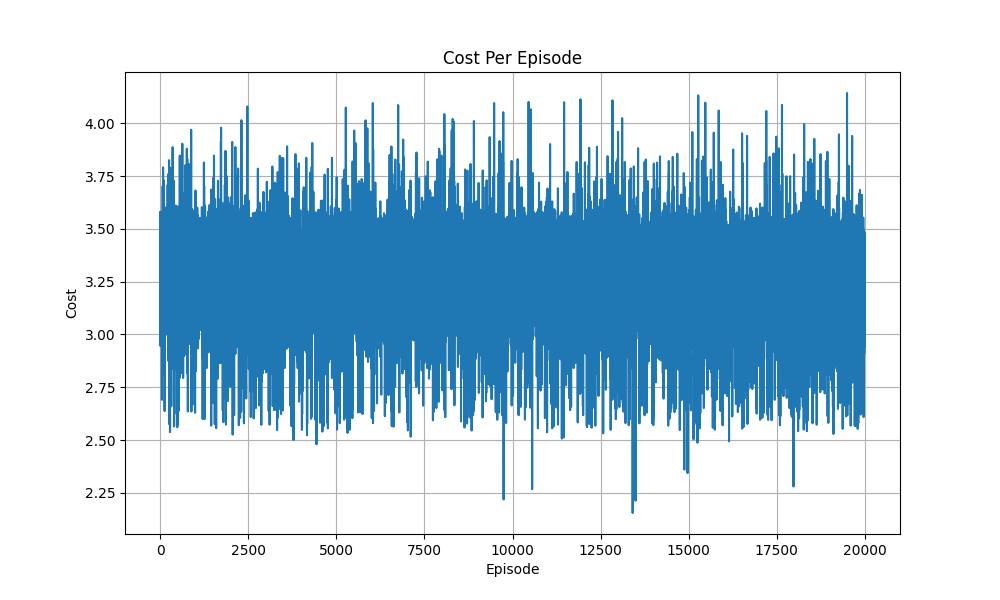

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(costs_history)
plt.title("Cost Per Episode")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.grid()
plt.show()

**4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.**

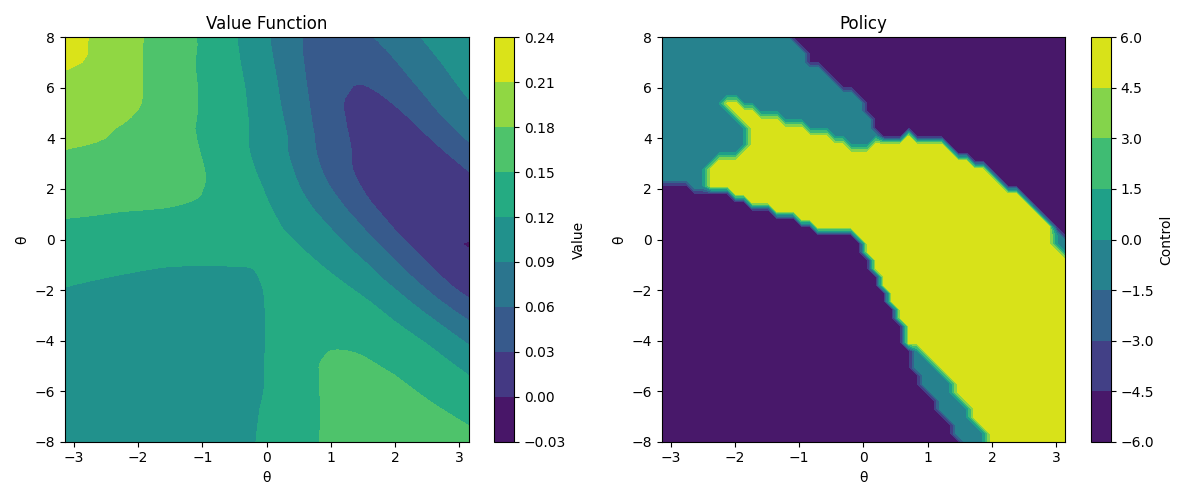

In [29]:
def plot_value_policy():
    # grid of states
    theta = np.linspace(-np.pi, np.pi, 50)
    theta_dot = np.linspace(-8, 8, 50)
    theta_grid, theta_dot_grid = np.meshgrid(theta, theta_dot)
    
    # value function and policy
    value_function = np.zeros_like(theta_grid)
    policy = np.zeros_like(theta_grid)
    
    for i in range(len(theta)):
        for j in range(len(theta_dot)):
            state = torch.tensor([theta[i], theta_dot[j]], dtype=torch.float32)
            with torch.no_grad():
                q_values = q_function(state)
                value_function[j,i] = torch.min(q_values).item()
                policy[j,i] = possible_controls[torch.argmin(q_values).item()]
    
    # Plot value function
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.contourf(theta_grid, theta_dot_grid, value_function)
    plt.colorbar(label='Value')
    plt.xlabel('θ')
    plt.ylabel('θ̇')
    plt.title('Value Function')
    
    # Plot policy
    plt.subplot(122)
    plt.contourf(theta_grid, theta_dot_grid, policy)
    plt.colorbar(label='Control')
    plt.xlabel('θ')
    plt.ylabel('θ̇')
    plt.title('Policy')
    plt.tight_layout()
    plt.show()

plot_value_policy()

## Testing
You can test your results with the code below which use the Q-function to create a controller send to the `animate_robot` function.
You can choose to save also a movie of the animation and toggle the animation with a disturbance.

In [33]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=False, save_movie=True)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAvIRtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DOhliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiZRgAQ7MAQvEwgyGH1uM4k2yJme2NrCEf
1et3jjVSqDCw+r7H/WCFxoXdA3+LIwLQIlEN4vX5b2C+zQHzQ2fvvWqjUq9aNu3EtiYXsnvASOIf
l+rVy9k4jM0fQozkmz686awrq/0JP/wHEZ5HxV6D6ogIfq2IPFjaNM2xEvdPVhQ00IosdtX+BT8h
otcUT/d7qyqyMVichmsEjJf+GSv9KgqH/Qr4wFoCWtHci5Xu+mUn1NauuhWOazymWvlfnp2P8Xtn
rGfqYO8ABZbE2jQvl/bvZyxMzASWpapBIGfgt9jw72WnvnbOSwSOq/95ZL5tztAi6b64LPRAG2PA
7ciJ4kQ8iWE2H2tjYp7xMBSTZuqvfyAnAAADAAADAAADAFrxtrti5WcckQs3DX3ugC0BtV3r09Lt
tXXNIxp8mSvHlsxZHBiP8rGWoMtxO1Kzx3wEqDMSRjXmRjE6m+6XQQDJRdT/QANou+MWa+1gNEOD
hceAW9Z/yhjwe9P5KXgtVRco8D5Mb9sF7knA8XIFI7cKualR9cX+AvzNsC3czTwqD8T+1QV4s5EQ
oBFCP7NU5yMZD4UzNk9JvMrIyGQYucUV46UaBVU06qjZ60+DWGFqnAn84WM8+IiCyw7yIBNwHP/l
gfBirqHRd1ala6t1nlohMLwX0CIWU0fXzT0TbWM9/Mjd3cjAd8vsbT6WM/Mgzein/6JydwqlEYXA
hbZ+dHDQuMi64VFsUozdyzoOa8QU3m/p/hOmunCX7cfEaLbWZer1hSZRL8qHMjhfBbKBotiaDVZ+
2dCQ3bCuUI21WVo/C2i7IBsb5gAAAwAAAwAACHLpZARDg7D9sUJGj2kFGltXifbAIA8Iu7CSHyht
gvd+55/bdL2XUOCMl81g6pYvjxMWfsLbe74Hl1k7d22JK2QHK9MoThyrJohoUpfp1T9OiM9EIcWT
0vykXCJ2vcKd9LAmqaHAreC+KPnQxjMZjG7e0tCnK5zZoDA2ufUfTQVhzVNm8xC/IkC9ARVk2Cug
7teckj3Zj3ysF4gehS+0WWJuXxV2P07T3ClKIZhTN5GocQ3+kckvG2O2fsE3eQ8gxwC4K7Zo/HOg
X2GLsMX2hVxlwJfGoqutPJOoeAbzpFGMb2HgTc9+7pLPyHlU7upSH+Z+oOwoIlEfOJtiBFItJ005
Ser72rMj8o4rR2ij/dBssl0sMBLAYJ5wlp9o11WSOtrmk8SV3+UDREAYKgn1meqqWhNYO2vBJ3Bj
7ZMhTBYNAlimQAeAHUWVcrnofn+vuOIbj02eD2cked0SsCopTV70ukWQv7JVqROElixQh3/e3ASG
zeiLfZaDQ67MA87+qHj48AfDY58zj2knC19tcb1Liyl2aa2lwnDBAssPqBVIoxHw8oBEiHrRpmrm
g/0ldFQJCpAJLWbQ7ts64ruQHFwNQp5vb+FlxpBJjZM3yUEHtvEysqDnt/AIFgFrAfbXf7Xmv5F+
TrgsDPXR3KX36iLhKhQ/XIvMuwOwySUUvoksuJ+uBmbi7r+cC4aX4MPcQpXYsKEIS4T5CMwYthVz
5/9U3piyWz0SdbrcQ/phPJxpB9/l9cHZJakZQDUaLlTDgawRlcMqZ7338MGdhnnRunDhzhTg9uhR
53dVDtoGSCFAlc/kzzPP2itaO0WyUzD0jv0aJDvEMXqonTrd6Neg9HUDLO6LZ6GJQOWBie8mxC7W
jDw9kwF2f/I5PtgfsfsuyrsZlmDhSPkuJNIk3/m/++64yRvSNQ1u8Cb7VwSdwP3TNxKT7IeBOIMk
fXwQG6OOWsa9O5qc3vvFuDgnMuLo8nAdTW1WjZs1kLgs+Q/+TC0gzWe2W+3crApQSE9S+Y2HJQU+
1MTvIPpWhmTqdOXG/QfCGZeWQsJjEN+VDFspx9O4nlDFE3Xho3oDMw57XhGA2xNEl08fXpVf/KlK
YfnMXu2mzcJY4XkP7H2qwYnJ4mMssoXJg4hcIY6TD3FC7dBfFDWLAhtKdvf+wuO3wAdHosjzTVSH
F2J3uX+0bc3kBwCmXV4ckSJjjV7eXAFicrLMne3s5qZT//871knCqBqPJVpJJFb5MyVcPBqI1xCS
8Ey+KRA3ioM+jFiY2lhZ7yY9TyBDJTzW0YTUdKHoo1uJ8840vKj6r/Cf8K9W/WFwN2SZBSi7Fnet
kAOG+RcWbT6zpMIZNozbpVdlw+5HuTdGtX0vqYk5w4BP4aPHo/tLNkWo/k6if4DAkiJjSC13OXbw
Jyjbps9j+mcxlVGq2PmJqnFUt5T/56YlxMqkysVOn7GbCFCA2kKqBSajApiZzCQ+FcgtBUNq6oD+
W9SZxdUxdRmQRjDH+/5HJG+P4tDJ5UDxPO0i5N3l7qp0Rz/qmelbDxhxI8xG/ot7gbgJ15z/TDuE
XPGh2SN+vfQCe5peuvXIFJ+XPESB+IG1JpKPRda7/3NYLjL14al1l/zdZmnl3hPby3WDAMy5syP9
dDLMBHKJf0DyGbh6Q0bJT7VGqxhpTCeEOMWh165jxdeW4bUwiAUXaYHWvDO3UvEvz7+Xguewo/wj
mazfCfQ7YScZ9HE5JADBJ